In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avkrylovv","key":"052e90e6d6225e0650f1e999540f4ec8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d volkandl/cartoon-classification

100% 11.5G/11.5G [06:27<00:00, 30.7MB/s]
100% 11.5G/11.5G [06:27<00:00, 31.9MB/s]


In [5]:
from IPython.display import clear_output
! unzip '/content/cartoon-classification.zip' -d '/content/cartoon'
clear_output()

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
testdir='/content/cartoon/cartoon_classification/TEST'
traindir = '/content/cartoon/cartoon_classification/TRAIN'

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [10]:
train_transform = v2.Compose([v2.Resize([224,224]),v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.Resize([224,224]), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [11]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=transform)

In [12]:
m=int(0.5*len(train_dataset))
n=len(train_dataset)
split_1, split_2 = torch.utils.data.random_split(train_dataset, lengths=[m,n-m])

In [13]:
split_1[0]

(Image([[[0.6980, 0.6941, 0.7059,  ..., 0.9843, 0.9843, 0.9843],
         [0.7020, 0.6980, 0.7137,  ..., 0.9843, 0.9843, 0.9843],
         [0.7137, 0.7137, 0.7294,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.9961, 1.0000, 1.0000,  ..., 0.5490, 0.5725, 0.6275],
         [0.9961, 0.9961, 0.9961,  ..., 0.5647, 0.6314, 0.6824],
         [0.9882, 0.9961, 0.9961,  ..., 0.4471, 0.5137, 0.5882]],
 
        [[0.4157, 0.4157, 0.4353,  ..., 0.8902, 0.8902, 0.8902],
         [0.4275, 0.4275, 0.4431,  ..., 0.8902, 0.8902, 0.8902],
         [0.4431, 0.4431, 0.4588,  ..., 0.8902, 0.8902, 0.8902],
         ...,
         [0.9961, 1.0000, 1.0000,  ..., 0.3961, 0.4235, 0.4863],
         [0.9725, 0.9765, 0.9765,  ..., 0.4039, 0.4745, 0.5373],
         [0.9098, 0.9137, 0.9137,  ..., 0.2824, 0.3569, 0.4392]],
 
        [[0.2667, 0.2667, 0.2824,  ..., 0.7961, 0.7961, 0.7961],
         [0.2745, 0.2745, 0.2902,  ..., 0.7961, 0.7961, 0.7961],
         [0.2902, 0.2902, 0.3059,  ..., 0.7961, 0.7961, 

In [14]:
train_dataset.classes

['Familyguy',
 'Gumball',
 'Tsubasa',
 'adventure_time',
 'catdog',
 'pokemon',
 'smurfs',
 'southpark',
 'spongebob',
 'tom_and_jerry']

In [15]:
m1=int(0.1*len(train_dataset))
n1=len(train_dataset)
m2=int(0.1*len(test_dataset))
n2=len(test_dataset)
train_dataset_small,_=torch.utils.data.random_split(train_dataset, lengths=[m1,n1-m1])
test_dataset_small,_=torch.utils.data.random_split(test_dataset, lengths=[m2,n2-m2])

In [16]:
len(train_dataset_small)

11961

In [17]:
len(test_dataset_small)

1811

In [18]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

In [19]:
# batch_size=32
# train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)

In [20]:
batch_size=32
train_loader = DataLoader(train_dataset_small, batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset_small, batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)

In [21]:
#show_batch(train_loader);

In [22]:
#show_batch(test_loader)

In [23]:
import torchvision.models as models

In [24]:
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
model.to(device);

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 58.4MB/s]


In [25]:
! pip install torchinfo

In [26]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

In [27]:
num_cls=len(train_dataset.classes)

In [28]:
model.classifier[3]=nn.Linear(1024,num_cls)

In [29]:
model.to(device);

In [30]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 10]                   --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

In [31]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [32]:
!pip install pytorch-ignite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 3.9 MB/s eta 0:00:00


In [33]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [34]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [35]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=num_cls)}

In [36]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [37]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [38]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [39]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [40]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [41]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [42]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [43]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 91.29 Сред. ошибка: 0.29690
Результат валидации - Эпоха: 1  Сред. точность: 77.97 Сред. ошибка: 0.87510


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 99.58 Сред. ошибка: 0.01391
Результат валидации - Эпоха: 2  Сред. точность: 92.82 Сред. ошибка: 0.40390


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 99.77 Сред. ошибка: 0.00696
Результат валидации - Эпоха: 3  Сред. точность: 92.16 Сред. ошибка: 0.36617


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 90.76 Сред. ошибка: 0.34155
Результат валидации - Эпоха: 4  Сред. точность: 78.91 Сред. ошибка: 1.18561


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 94.15 Сред. ошибка: 0.27243
Результат валидации - Эпоха: 5  Сред. точность: 86.42 Сред. ошибка: 0.69934


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.21 Сред. ошибка: 0.12082
Результат валидации - Эпоха: 6  Сред. точность: 87.36 Сред. ошибка: 0.60864


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.62 Сред. ошибка: 0.01214
Результат валидации - Эпоха: 7  Сред. точность: 90.89 Сред. ошибка: 0.51896


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 86.50 Сред. ошибка: 0.59054
Результат валидации - Эпоха: 8  Сред. точность: 75.81 Сред. ошибка: 1.28962


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 98.68 Сред. ошибка: 0.04916
Результат валидации - Эпоха: 9  Сред. точность: 91.83 Сред. ошибка: 0.32852


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.92 Сред. ошибка: 0.00224
Результат валидации - Эпоха: 10  Сред. точность: 93.04 Сред. ошибка: 0.23467


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.85 Сред. ошибка: 0.00298
Результат валидации - Эпоха: 11  Сред. точность: 93.65 Сред. ошибка: 0.35526


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.83 Сред. ошибка: 0.00527
Результат валидации - Эпоха: 12  Сред. точность: 94.37 Сред. ошибка: 0.22896


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.86 Сред. ошибка: 0.00431
Результат валидации - Эпоха: 13  Сред. точность: 92.82 Сред. ошибка: 0.37233


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.92 Сред. ошибка: 0.00258
Результат валидации - Эпоха: 14  Сред. точность: 96.30 Сред. ошибка: 0.16874


  0%|          | 1/374 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 93.35 Сред. ошибка: 0.53478
Результат валидации - Эпоха: 15  Сред. точность: 86.20 Сред. ошибка: 0.81770


State:
	iteration: 5610
	epoch: 15
	epoch_length: 374
	max_epochs: 15
	output: 0.00012732643517665565
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

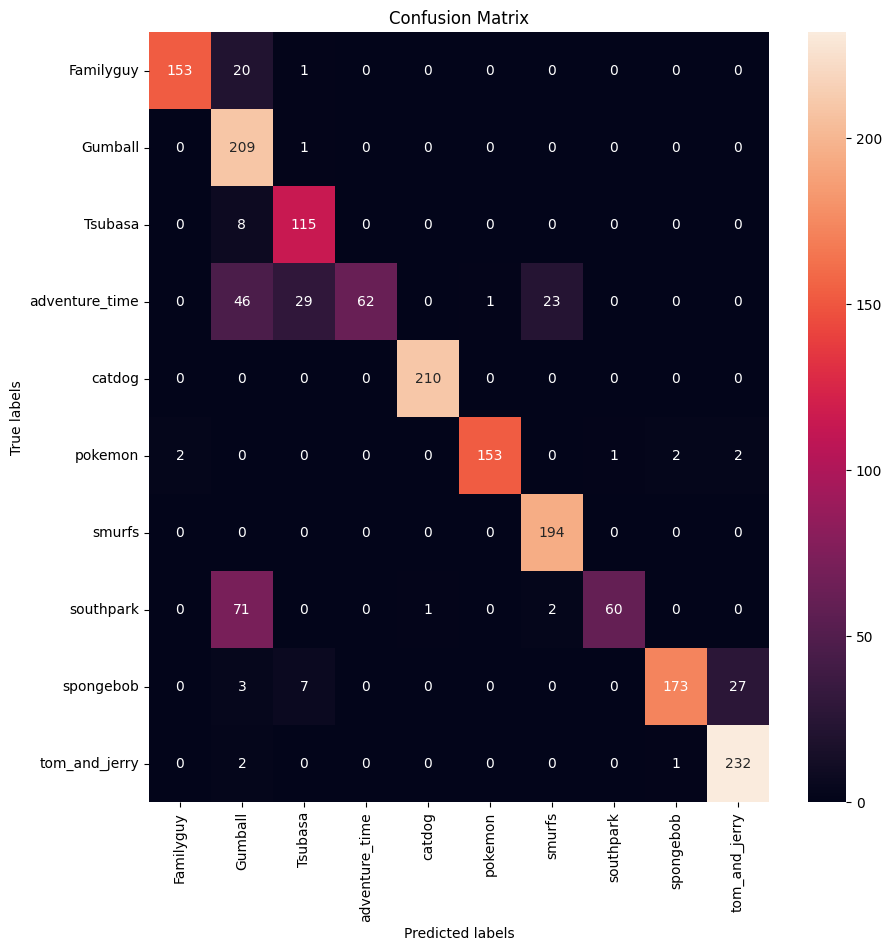

In [44]:
trainer.run(train_loader, max_epochs=20)